In [1]:
# Generate the discretized matrix
import numpy as np
from scipy.sparse import diags, eye, kron

def tridiag(a, b, c, n):
    # Create a tridiagonal matrix
    return diags([a*np.ones(n-1), b*np.ones(n), c*np.ones(n-1)], [-1, 0, 1], format='csr')

def fd3d(nx, ny, nz, alpx, alpy, alpz, dshift):
    # Create tridiagonal matrices tx, ty, tz
    tx = tridiag(-1+alpx, 2, -1-alpx, nx)
    ty = tridiag(-1+alpy, 2, -1-alpy, ny)
    tz = tridiag(-1+alpz, 2, -1-alpz, nz)

    # Compute A using Kronecker products
    A = kron(eye(ny), tx) + kron(ty, eye(nx))
    if nz > 1:
        A = kron(eye(nz), A) + kron(tz, eye(nx*ny))

    # Subtract dshift times identity matrix from A
    A -= dshift * eye(nx*ny*nz)

    return A

## Problem 1 (Lanczos VS Arnoldi)

### **Lanczos Algorithm**

The Lanczos algorithm is specifically designed for real symmetric matrices. It constructs an orthonormal basis for the Krylov subspace and the corresponding tridiagonal matrix representation of the original matrix in this basis.

Here is a Python implementation:

In [2]:
import numpy as np

def Lanczos(A, n, k):
    """
    Perform Lanczos algorithm on matrix A with n steps, returning the tridiagonal matrix T
    and the matrix V of Lanczos vectors.

    :param A: Square, symmetric matrix
    :param n: The size of the matrix A
    :param k: Number of iterations
    :return: T, V
    """
    V = np.zeros((n, k+1))
    alpha = np.zeros(k)
    beta = np.zeros(k+1)
    q = np.random.rand(n)
    q = q / np.linalg.norm(q)
    V[:, 0] = q

    for j in range(k):
        w = A.dot(V[:, j]) - beta[j] * V[:, j-1] if j > 0 else A.dot(V[:, j])
        alpha[j] = np.dot(w, V[:, j])
        w = w - alpha[j] * V[:, j]
        beta[j+1] = np.linalg.norm(w)
        if beta[j+1] > 1e-16 and j < k - 1:
            V[:, j+1] = w / beta[j+1]
        else:
            break

    T = np.diag(alpha) + np.diag(beta[1:k], 1) + np.diag(beta[1:k], -1)
    return T, V[:, :k]

### **Arnoldi Algorithm**

The Arnoldi algorithm is a generalization of the Lanczos algorithm that can be applied to non-symmetric matrices. It constructs an orthonormal basis for the Krylov subspace and the corresponding upper Hessenberg matrix representation of the original matrix.

Here is a Python implmentation

In [3]:
def Arnoldi(A, n, k):
    """
    Perform Arnoldi algorithm on matrix A with n steps, returning the Hessenberg matrix H
    and the matrix V of Arnoldi vectors.

    :param A: Square matrix
    :param n: The size of the matrix A
    :param k: Number of iterations
    :return: H, V
    """
    V = np.zeros((n, k+1))
    H = np.zeros((k+1, k))
    q = np.random.rand(n)
    q = q / np.linalg.norm(q)
    V[:,0] = q

    for j in range(k):
        w = A.dot(V[:, j])
        for i in range(j+1):
            H[i,j] = np.dot(w, V[:, i])
            w = w - H[i,j] * V[:, i]
        H[j+1,j] = np.linalg.norm(w)
        if H[j+1,j] > 1e-16:
            V[:, j+1] = w / H[j+1,j]

    return H[:k, :], V[:, :k]

In this problem, we study the numerical stability issue for algorithms using short-term recurrence. Please first show that the Lanczos basis $V_{lanczos}$ and the Arnoldi basis $V_{arnoldi}$ returned in the following cell should be identical in theory. Then run the code. Do you see any difference in these two bases numerically? Pleae explain the reason.

In [4]:
import matplotlib.pyplot as plt

n1, n2, n3 = 30, 30, 30

n = n1*n2*n3

A = fd3d(n1, n1, n1, 0, 0, 0, 3)

k = 300 # Krylov subspace dimension

T_lanczos, V_lanczos = Lanczos(A, n, k)

H_arnoldi, V_arnoldi = Arnoldi(A, n, k)

print("The condition number of V_lanczos is", np.linalg.norm(V_lanczos.T@V_lanczos, 2))

print("The condition number of V_arnoldi is", np.linalg.norm(V_arnoldi.T@V_arnoldi, 2))

The condition number of V_lanczos is 2.000784460380134
The condition number of V_arnoldi is 1.0000000000009546


Your answer:
First it is important to note that since the Arnoldi method can be used on nonsymmetric matrices, we have to orthogonalize against all previous vectors:

\begin{align}
Av_m - \sum_{i=1}^m \langle Av_m, v_i\rangle v_i.
\end{align}

Now using this set-up, we see:
\begin{align}
\mathbf{AV}_m &= \mathbf{V}_{m+1}\bar{\mathbf{H}_m}\\
\mathbf{V}^\top_{m} \mathbf{AV}_{m} &= \mathbf{V}_{m}^\top \mathbf{V}_{m+1}\bar{\mathbf{H}_m}\\
&= \mathbf{V}_m^\top\begin{bmatrix} \mathbf{V}_m & v_{m+1}\end{bmatrix} \begin{bmatrix} \mathbf{H}_m \\ h_{m+1,m}e_m^\top\end{bmatrix}\\
&= \begin{bmatrix} \mathbf{I} & \vec{0}\end{bmatrix}\begin{bmatrix} \mathbf{H}_m \\ h_{m+1,m}e_m^\top\end{bmatrix}\\
&= \mathbf{H}_m + 0.
\end{align}

Now suppose $\mathbf{A}$ is symmetric, so we will then want to use the Lanczos algorithm. Since $\mathbf{V}^\top_{m} \mathbf{AV}_{m}$ is symmetric, then through the above computation, we have $\mathbf{H}_m$ must also be symmetric. Recall that $\mathbf{H}$ is upper-Hessenberg, which means that $\mathbf{H}_m$ must be tridiagonal. In this symmetric case, we have 3 non-zero entries per row, so we can rewrite the ortogonalizion process as


\begin{align}
Av_m - \sum_{i=1}^m \langle Av_m, v_i\rangle v_i &= Av_m - \sum_{i=1}^{m-2}\langle Av_m, v_m\rangle v_m - \langle Av_m, v_{m-1}\rangle v_{m-1} - \langle Av_m, v_i\rangle v_i\\
&= - \langle Av_m, v_{m-1}\rangle v_{m-1} - \langle Av_m, v_i\rangle v_i,
\end{align}

since the other entries are zero, so the projection will just be zero in the first $m-2$ terms. This is why we can use short- term recurrence. So yes, mathematically the basis from Arnoldi should be equivalent to the basis from Lanczos.

However, there is no such thing as a ``free lunch``. There are roundings in these short term recurrence computations, and these round-offs actually perturb the values away from orthogonality. This could be visualized by computing $\langle v^1_{\text{Lanczos}}, v^{300}_{\text{Lanczos}}\rangle$ and compare to the expected value of 0. (they are orthogonal after all ;P). This lose of orthogonality is why in the above code, we see that $\kappa(V_{\text{Arnoldi}}) \approx 1$, which is what we would expect since $\|V_{\text{Arnoldi}}^\top V_{\text{Arnoldi}}\| \approx \|\mathbf{I}\| \approx 1$, but for the mathematically equivalent basis $\kappa(V_{\text{Lanczos}})$ is more than double what it should be. 


In [43]:
print("The Inner Product of V_lanczos(1) and V_lanczos(300) is", np.inner(V_lanczos[:,0],V_lanczos[:,299]))

The Inner Product of V_lanczos(1) and V_lanczos(300) is -0.0027425254165546306


## Problem 2 (CG)

Let us first study the convergence of CG with a few examples.

2.1 From the lecture, we know that CG is nothing but a smart way to implement the orthogonal projection method when a Krylov subspace $\mathcal{K}_m(A,r_0)$ is used to construct the projection subspace $V$. Recall the optimal property of orthgonal projection framework: the solution will minimize the A-norm of $x_m-x_{\ast}$ from all of the possible $x_m \in x_0 + \mathcal{K}_m(A,r_0)$, where $x_{\ast}$ is the true solution of the linear system. Therefore, in theory,  $\Vert x_m - x_{\ast}\Vert_A$ should be a non-increasing function of the iteration number $m$. Please run the following code and explain why the error VS iteration number curve does increase at certain iterations.

Your answer: As stated above, we only proved that $\|x_m - x^\ast\|_{\mathbf{A}}$ would be a non-increasing function of the iteration number, $m$. However, the code below plots $\|r_m\|_2$ vs. iteration number $m$ for CG, where we have no such guarentees of non-increasing, as we are using a different norm and looking at the residuals, not the distance from the solution.

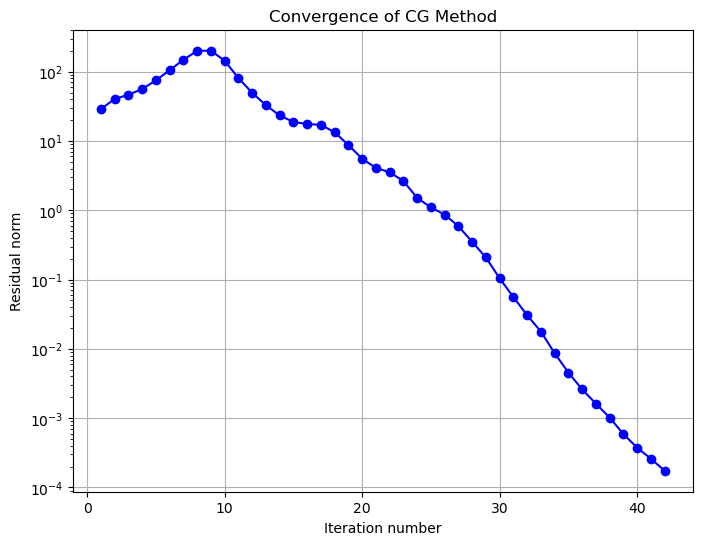

In [5]:
from scipy.sparse.linalg import cg
import matplotlib.pyplot as plt

n1, n2, n3 = 10, 10, 10

n = n1*n2*n3

A = fd3d(n1, n1, n1, 0, 0, 0, 0.24)

b = np.random.random(n)


# Initialize a list to store the residuals
residuals = []

# Define a callback function to store the residual norm
def callback(xk):
    residual = np.linalg.norm(b - A.dot(xk))
    residuals.append(residual)

# Solve the system Ax = b using the Conjugate Gradient method with a callback
x, info = cg(A, b, atol=1e-6, callback=callback)

# Plotting the convergence (i.e., the residual norm at each step)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(residuals) + 1), residuals, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration number')
plt.ylabel('Residual norm')
plt.title('Convergence of CG Method')
plt.grid(True)
plt.yscale('log') # Use logarithmic scale for better visualization if needed
plt.show()



2.2 The following code can be used to check whether the previous test matrix $A$ is SPD. Can you explain why this simpe check works?

In [6]:
import numpy as np
from scipy.sparse.linalg import eigsh

# Find the smallest eigenvalue using eigsh
# k is the number of smallest eigenvalues you want to find
# which='SA' means you are interested in the smallest algebraic eigenvalues
eigenvalues, eigenvectors = eigsh(A, k=1, which='SA')

# Print the smallest eigenvalue
print("The smallest eigenvalue is:", eigenvalues[0])

print("||(A-A')*ones|| is:", np.linalg.norm((A@np.ones(n)-A.T@(np.ones(n)))))

The smallest eigenvalue is: 0.003042158313015827
||(A-A')*ones|| is: 0.0


Your answer: We are computing two quantities here. First we are printing out the single ($k=1$ after all) smallest eigenvalue of $A$. Because we are doing this, if $\lambda_{\text{min}}>0$, then we know that all other eigenvalues $\lambda_i\geq \lambda_{\text{min}}>0, \forall i = 1,\cdots, n-1$, which is an equivalent definition of being positive definite.

Secondly, we are computing the row sum of $A$ and subtracting off the row sum of $A^\top$. If even one row sum of $A$ doesn't equal the row sum of $A^\top$, then we cannot hope to have a symmetric matrix (since $A\neq A^\top$). This means an element of the final difference vector $(A-A^\top)\vec{1} \neq 0$. Lastly taking the norm of a nonzero vector, by the ``positive definiteness'' property of norms, then the norm will be positive. We only get that the norm is zero if the vector is $\vec{0} \implies A_i=A^\top_i, \forall i=1,\cdots,n$, the very definition of symmetric.

Since we have checked both symmetry and positive definiteness, then the matrix is SPD if it passes both checks.

2.3 Can you explain the weird convergence curve from the following code?

Your answer: Weird indeed! Sometimes when we plot the convergence, we see a non-decreasing function vs. iteration number. This is simply explained by the fact that $\mathbf{A}$ is indefinite. Notice ``tx = tridiag(0,2,-2)``, ``ty = tridiag(1,2,-3)``, and ``tz = tridiag(2,2,-4)`` given teh current arguments. Using Gergorin, we are unable to guarentee that any of these have strictly positive eigenvalues. Additionally, we have a shift of -2, which means that all the eigenvalues are now 2 lower than they were originally. This means we have an indefinite system. :(

Sometimes however, we see decreases in the residual norm even for an indefinite matrix. This is nothing to be alarmed about though, as we started with a random inital guess, so sometimes when we do the linear solve, we get a smaller residual for the same matrix.

Recall: The $\mathbf{A}$ "norm" is only a norm iff $\mathbf{A}$ is SPD. Otherwise we could get a negative value for the "norm", which means it cannot be a norm at all!

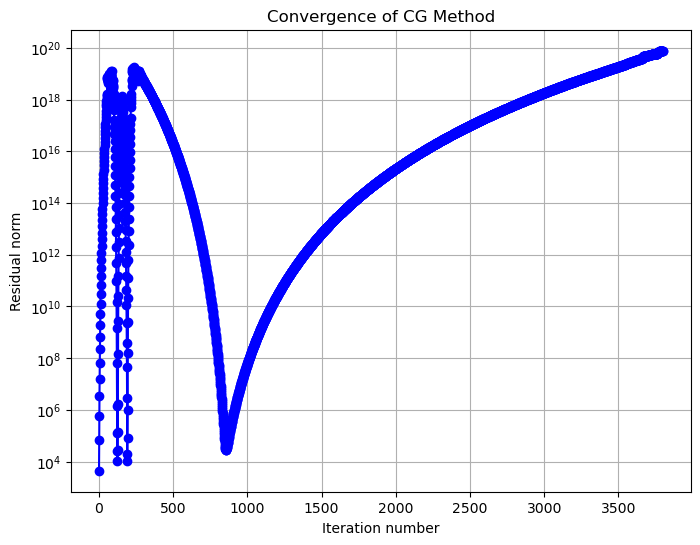

In [32]:
from scipy.sparse.linalg import cg
import matplotlib.pyplot as plt

n1, n2, n3 = 10, 10, 10

n = n1*n2*n3

A = fd3d(n1, n1, n1, 1, 2, 3, 2)

b = np.random.random(n)


# Initialize a list to store the residuals
residuals = []

# Define a callback function to store the residual norm
def callback(xk):
    residual = np.linalg.norm(b - A.dot(xk))
    residuals.append(residual)

# Solve the system Ax = b using the Conjugate Gradient method with a callback
x, info = cg(A, b, callback=callback, atol=1e-6)

# Plotting the convergence (i.e., the residual norm at each step)
plt.figure(figsize=(8, 6))
plt.plot(residuals, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration number')
plt.ylabel('Residual norm')
plt.title('Convergence of CG Method')
plt.grid(True)
plt.yscale('log') # Use logarithmic scale for better visualization if needed
plt.show()

## Problem 3 GMRES

3.1. We plan to test the convergence of GMRES for solving two linear systems $A_1x=b$ and $A_2x=b$ where $A_1$ and $A_2$ are supposed to have the same eigenvalues. Please read the following code and prove $A_1$ and $A_2$ indeed have the same eigenvalues.

In [13]:
# Import the necessary library
import numpy as np

n = 3000 # matrix size

# Define the eigenvalues, each repeating 1000 times
eigenvalues = np.repeat([1, 10, 100000], 1000)

# Define the first matrix
R = np.random.rand(3000,3000)
Q, R = np.linalg.qr(R)
A1 = (Q.T@np.diag(eigenvalues))@Q

# Define the third matrix A2 as a lower triangular matrix
A2 = np.tril(np.random.rand(3000, 3000), -1) + np.diag(eigenvalues)

b = np.random.random(n)

Your proof: Let $\mathbf{\Lambda} = diag(eigenvalues)$. By the Spectral Theorem (for more information, see: [Spectral Theory](https://www.amazon.com/Spectral-Theory-Concepts-Applications-Mathematics-ebook/dp/B085VVPQM2)), we know that for $\mathbf{A}_1$, the eigenvalues are exactly $\mathbf{\Lambda}$. For $\mathbf{A}_2$, we have a lower triangular matrix, which means that the eigenvalues could be read directly off of the diagonal, which by construction of $\mathbf{A}_2$, is $\mathbf{\Lambda}$. Since the eigenvalues of $\mathbf{A}_1$ and $\mathbf{A}_2$ are exactly the same, namely $\mathbf{\Lambda}$, then these two matrices have the same eigenvalues.

3.2. We then test the convergence of GMRES on $A_1x=b$. Please run the following code and prove why GMRES can converge in a small number of iteration for the first matrix.

In [14]:
from scipy.sparse.linalg import gmres
import matplotlib.pyplot as plt

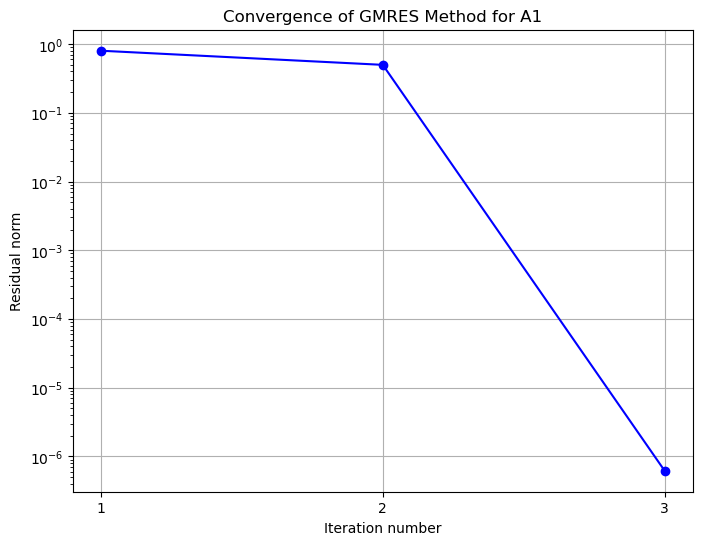

In [15]:
# Callback function to capture the residual norm history
residual_norms = []
def callback(residual):
    residual_norm = np.linalg.norm(residual)
    residual_norms.append(residual_norm)
# Solve the system using GMRES, tracking residual norms
x, exitCode = gmres(A1, b, restart = 300, atol = 1e-6, maxiter = 300, callback=callback)

# Plotting the convergence of GMRES for A1
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(residual_norms) + 1), residual_norms, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration number')
plt.ylabel('Residual norm')
plt.title('Convergence of GMRES Method for A1')
plt.grid(True)
plt.yscale('log')  # Use logarithmic scale for better visualization if needed
plt.xticks(range(1, len(residual_norms) + 1))  # Ensure x-ticks match iteration numbers
plt.show()

Your proof: First notice that $\mathbf{A}_1$ is orthogonally diagonalizable, so the bound by Eisenstat, Elman, and Schultz tells us
\begin{align}
\|r_m\|_2 &\leq \kappa_2(\mathbf{X}) \min_{p\in \mathcal{P}_{m-1}, p(0)=1} \max_{\lambda\in\Lambda(A)} |p(\lambda)|\|r_0\|_2
\end{align}
However, we can adjust this bound for our problem. First $\mathbf{A}_1 = \mathbf{Q}^\top\mathbf{\Lambda Q}$, as it is orthogonally diagonalizable, and $\kappa_2(Q) = 1$. Additionally, we have 3 exact clusters of eigenvalues, so we only need to construct a degree 3 polynomial. This means we would expect to converge in about 3 iterations, which is what was numerically verified above.

3.3. We then test the convergence of GMRES on $A_2x=b$. Please run the following code and explain why GMRES can converge slowly for this problem.

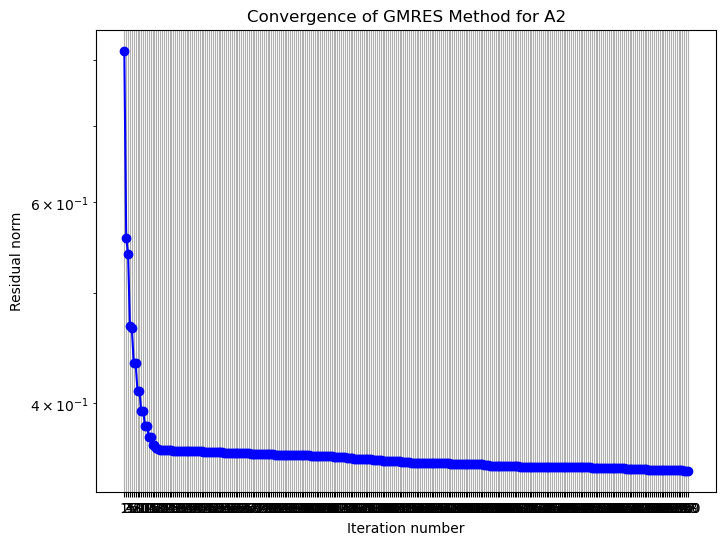

In [16]:
# Callback function to capture the residual norm history
residual_norms = []
def callback(residual):
    residual_norm = np.linalg.norm(residual)
    residual_norms.append(residual_norm)
# Solve the system using GMRES, tracking residual norms
x, exitCode = gmres(A2, b, restart = 300, atol = 1e-6, maxiter = 300, callback=callback)

# Plotting the convergence of GMRES for A1
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(residual_norms) + 1), residual_norms, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration number')
plt.ylabel('Residual norm')
plt.title('Convergence of GMRES Method for A2')
plt.grid(True)
plt.yscale('log')  # Use logarithmic scale for better visualization if needed
plt.xticks(range(1, len(residual_norms) + 1))  # Ensure x-ticks match iteration numbers
plt.show()

Your explanation: The Eisenstat, Elman, Schultz bound only works for diagonalizable matrices. Since $\mathbf{A}_2$ is nonnormal, we cannot expect the same bound to hold, and in fact, it doesn't. As Francesco Brarda wrongly believes, eigenvalues of a matrix don't tell the complete picture; sometimes the matrix structure itself matters.

3.4 In the last problem, make sure you understand the arguments in gmres function. Please explain why you see the difference in terms of the convergence speed when we apply GMRES to solve the same problem $A_3x=b$.

The only difference between the two codes is one restarts after 20 iterations; whereas, the other restarts after 100 iterations. Notice, one way of interpretting this restart is that you are constructing a degree $d$ polynomial. Five rounds of degree 20 polynomials is not as good as one round of degree 100 polynomial, so we should expect to see that restarting less frequently will allow for smaller error in the same amount of iterations. This ie exacly what we observe. After 300 iterations, the restart every 20 gets to a residual error of 5e-4; whereas, the restart every 100 gets down to 1e-5, which is better. 

However, since we are doing GMRES, we know that we don't have a constant amount of work each iteration, as we have to do the orthogonalization work, so the more vectors we have (the larger restart will have to store more), the more work we have to orthogonalize. This means while in the same amount of iterations GMRES[100] does more work each iteration than GMRES[20]. This is why the convergence speed cannot be calculated purely by the convergence plots as there is a tradeoff between restarting and work per iteration.

In [17]:
n = 3000 # matrix size

# Define the eigenvalues, each repeating 1000 times
eigenvalues = np.random.rand(n)

# Define the third matrix
A3 = np.diag(eigenvalues)

b = np.random.random(n)

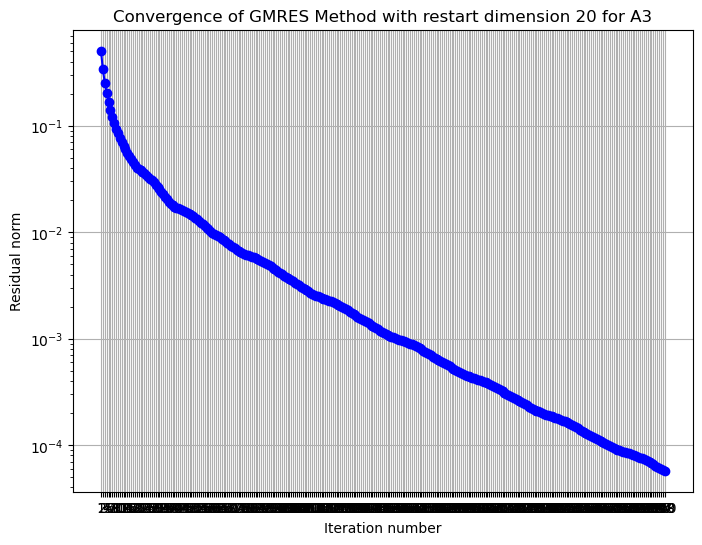

In [18]:
# First way to call GMRES
# Callback function to capture the residual norm history
residual_norms = []
def callback(residual):
    residual_norm = np.linalg.norm(residual)
    residual_norms.append(residual_norm)
# Solve the system using GMRES, tracking residual norms
x, exitCode = gmres(A3, b, restart = 20, atol = 1e-6, maxiter = 300, callback=callback)

# Plotting the convergence of GMRES for A3
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(residual_norms) + 1), residual_norms, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration number')
plt.ylabel('Residual norm')
plt.title('Convergence of GMRES Method with restart dimension 20 for A3')
plt.grid(True)
plt.yscale('log')  # Use logarithmic scale for better visualization if needed
plt.xticks(range(1, len(residual_norms) + 1))  # Ensure x-ticks match iteration numbers
plt.show()

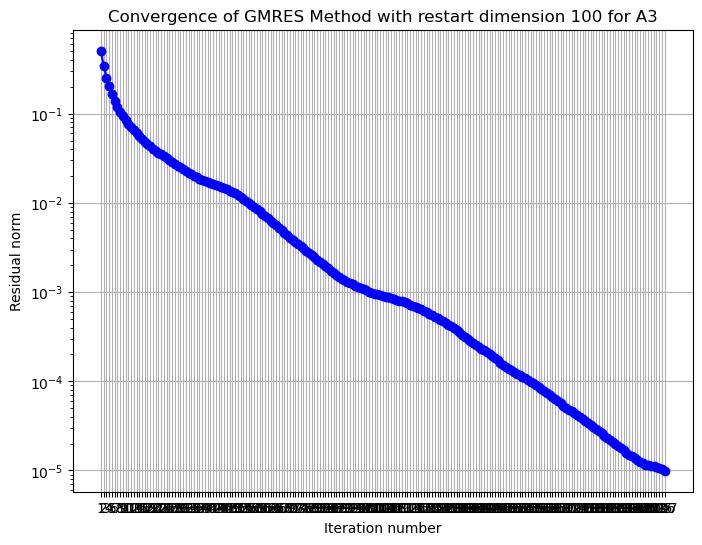

In [19]:
# Second way to call GMRES
# Callback function to capture the residual norm history
residual_norms = []
def callback(residual):
    residual_norm = np.linalg.norm(residual)
    residual_norms.append(residual_norm)
# Solve the system using GMRES, tracking residual norms
x, exitCode = gmres(A3, b, restart = 100, atol = 1e-6, maxiter = 300, callback=callback)

# Plotting the convergence of GMRES for A3
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(residual_norms) + 1), residual_norms, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration number')
plt.ylabel('Residual norm')
plt.title('Convergence of GMRES Method with restart dimension 100 for A3')
plt.grid(True)
plt.yscale('log')  # Use logarithmic scale for better visualization if needed
plt.xticks(range(1, len(residual_norms) + 1))  # Ensure x-ticks match iteration numbers
plt.show()

Your answer: